### Scattering

I will show how to compute the scattering cross section of a lossy dielectric cylindrical rod in vaccuum using the [`gyptis`](https://gyptis.gitlab.io) package.

In [55]:
import numpy as np
import gyptis as gp
import matplotlib.pyplot as plt

In [56]:
R = 0.5 # rod radius
eps_rod = 6-0.1j  # rod permittivity
eps_bg = 1 # background permittivity
wl = 1 # wavelength
pmesh = 10 # mesh parameter

First we will define the geometry

In [57]:
geom = gp.BoxPML(
    dim=2, # geometric dimension of the problem (2D)
    box_size=(3*wl, 3*wl), # size of the rectangular box
    pml_width=(wl, wl), # length of PMls
    Rcalc=0.9*3*wl/2, # the radius of a circle for computing cross sections
)

Add the the circular rod:

In [58]:
rod = geom.add_circle(0, 0, 0, R)
rod,*bg,  = geom.fragment(rod, geom.box)

In [59]:
geom.add_physical(bg, "box")
geom.add_physical(rod, "rod")

7

In [60]:
lmin = wl/pmesh

[geom.set_size(pml, lmin * 1) for pml in geom.pmls]
geom.set_size("box", lmin / eps_bg.real**0.5)
geom.set_size("rod",  lmin / eps_rod.real**0.5)
geom.build()

{'mesh': <dolfin.cpp.mesh.Mesh at 0x7fc2420e5a40>,
 'markers': {'line': <dolfin.cpp.mesh.MeshFunctionSizet at 0x7fc240927430>,
  'triangle': <dolfin.cpp.mesh.MeshFunctionSizet at 0x7fc240912ef0>}}

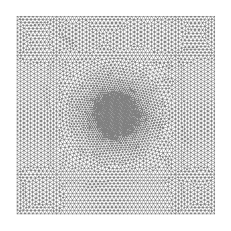

In [61]:
geom.plot_mesh()
plt.axis("off")
plt.show()

We define a plane wave incident on the scatterer

In [62]:
pw = gp.PlaneWave(wavelength=wl, angle=0, dim=2, domain=geom.mesh, degree=2)

Visualize the plane wave

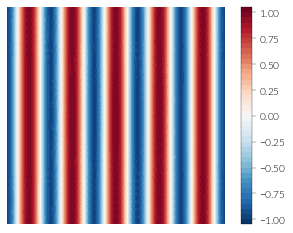

In [71]:
from gyptis.plot import plot
pw_proj = gp.helpers.project_iterative(pw.expression.real,V)
V = gp.dolfin.FunctionSpace(geom.mesh,"CG",2)
plot(pw_proj,cmap="RdBu_r")
plt.axis("off")
plt.show()

Define the material properties (relative permittivity and permeability).

In [72]:
epsilon = dict(box=eps_bg, rod=eps_rod)
mu = dict(box=1, rod=1)

We are ready to build the simulation object, first for TE polarization (in plane electric field).

In [73]:
sTE = gp.Scattering(
    geom,
    epsilon,
    mu,
    pw,
    degree=2,
    polarization="TE",
)

Solve the problem.

In [74]:
uTE = sTE.solve()

Plot the magnetic field.

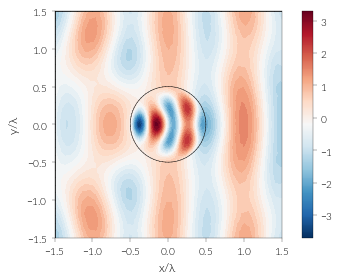

In [75]:
sTE.plot_field()
geom_lines = geom.plot_subdomains()
plt.xlabel(r"$x/\lambda$")
plt.ylabel(r"$y/\lambda$")
plt.tight_layout()

Compute the cross sections and check energy conservation (optical theorem).

In [76]:
csTE = sTE.get_cross_sections()
print(f"sigma_s = {csTE['scattering']}")
print(f"sigma_e = {csTE['extinction']}")
print(f"sigma_a = {csTE['absorption']}")
print(f"sum sigma_i = {csTE['scattering'] + csTE['absorption'] - csTE['extinction']}")
assert np.allclose(csTE["extinction"], csTE["scattering"] + csTE["absorption"], rtol=1e-2)

sigma_s = 1.9992363188443445
sigma_e = 2.2239610815470194
sigma_a = 0.23041255265255947
sum sigma_i = 0.005687789949884614


We now switch to TM polarization (out of plane electric field).

In [77]:
sTM = gp.Scattering(
    geom,
    epsilon,
    mu,
    pw,
    degree=2,
    polarization="TM",
)

In [78]:
uTM = sTM.solve()

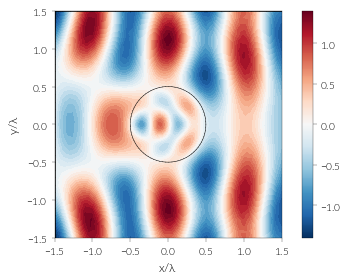

In [79]:
sTM.plot_field()
geom_lines = geom.plot_subdomains()
plt.xlabel(r"$x/\lambda$")
plt.ylabel(r"$y/\lambda$")
plt.tight_layout()

In [80]:
csTM = sTM.get_cross_sections()
print(f"sigma_s = {csTM['scattering']}")
print(f"sigma_e = {csTM['extinction']}")
print(f"sigma_a = {csTM['absorption']}")
print(f"sum sigma_i = {csTM['scattering'] + csTM['absorption'] - csTM['extinction']}")
assert np.allclose(csTM["extinction"], csTM["scattering"] + csTM["absorption"], rtol=1e-2)

sigma_s = 2.623514266938268
sigma_e = 2.846012061810182
sigma_a = 0.2281855848217992
sum sigma_i = 0.005687789949885502
